In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset

from mingpt.model import GPT
from mingpt.trainer import Trainer
from mingpt.utils import set_seed, setup_logging, CfgNode as CN

import math
import random
from create_dataset import create_dataset
from run_shortestroute import StateActionReturnDataset

max rtg is 0
max timestep is 241
number of parameters: 2.73M
running on device cuda
[[0 0 1 0 0 0 0 0 0 1 1 1]
 [1 0 1 0 1 0 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 1 1]
 [0 1 1 0 1 1 1 1 0 0 1 1]
 [0 1 1 1 0 0 0 1 1 0 1 1]
 [0 0 0 1 1 0 0 1 0 0 0 1]
 [1 1 1 0 0 0 0 0 0 1 1 0]
 [1 0 1 0 0 0 0 0 0 1 1 0]
 [1 1 0 0 1 1 1 1 0 0 0 0]
 [1 0 1 0 1 0 1 1 1 0 1 0]
 [1 1 1 0 1 1 0 1 0 0 0 1]
 [0 1 0 0 1 1 0 1 1 0 1 0]]


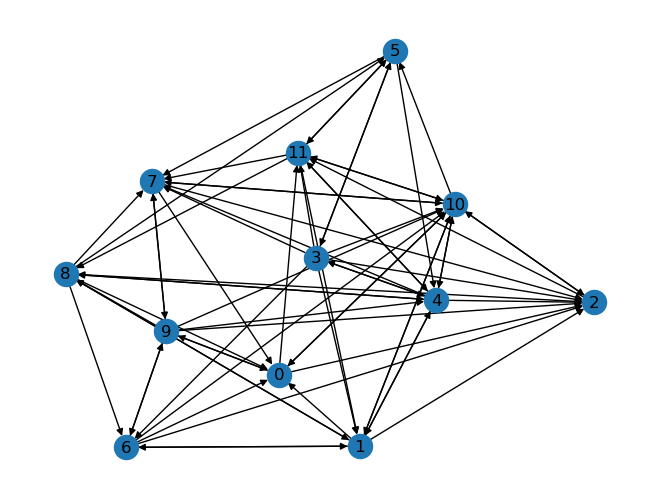

In [2]:
obss, actions, returns, done_idxs, rtgs, timesteps, env = create_dataset(10*1000)

train_dataset = StateActionReturnDataset(obss, 10 * 3, actions, done_idxs, rtgs, timesteps)

# Set up configs
C = CN()

## system
C.system = CN()
C.system.seed = 3407
C.system.work_dir = './out/decgpt'

# data
C.data = StateActionReturnDataset.get_default_config()

# model
C.model = GPT.get_default_config()
C.model.model_type = 'gpt-mini'
C.model.vocab_size = train_dataset.vocab_size
C.model.block_size = train_dataset.block_size
C.model.max_timestep = max(timesteps)

# trainer
C.trainer = Trainer.get_default_config()
C.trainer.learning_rate = 5e-4
C.trainer.max_epochs = 100
C.trainer.num_workers = 4
C.trainer.lr_decay = False
# C.trainer.lr_decay = True
# C.trainer.warmup_tokens = 30_000
# C.trainer.final_tokens = 100_000_000

model = GPT(C.model)

# initialize a trainer instance and kick off training
trainer = Trainer(model, train_dataset, C.trainer)

print(env.adj_mat)
env.draw()

In [49]:
trainer.run()

/home/icute/mambaforge/envs/dec-transformer-route/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
epoch 1 iter 155: train loss 0.16283. lr 5.000000e-04:  97%|█████████▋| 152/156 [00:02<00:00, 67.22it/s]/home/icute/mambaforge/envs/dec-transformer-route/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
epoch 1 iter 155: train loss 0.16283. lr 5.000000e-04: 100%|██████████| 156/156 [00:02<00:00, 65.96it/s]
epoch 2 iter 155: train loss 0.14138. lr 5.000000e-04: 100%|██████████| 156/156 [00:02<00:00, 65.95it/s]
epoch 3 iter 155: train loss 0.13261. lr 5.000000e-04: 100%|██████████| 156/156 [00:02<00:00, 65.06it/s]
epoch 4 iter 155: train los

In [50]:
state = torch.tensor(env.reset())
print(state)
action = 1
state, reward, done = env.step(action)
print(state, reward, done)
action = 5
state, reward, done = env.step(action)
print(state, reward, done)

tensor(0)
0 -1 False
0 -1 False


In [56]:
model.eval()
with torch.no_grad():
    done = True
    for i in range(1):
        # sample from the model
        state = torch.tensor(env.reset())
        state = state.type(torch.float32).to(trainer.device).unsqueeze(0).unsqueeze(0)
        rtgs = [-1]
        # first state is from env, first rtg is target return, and first timestep is 0
        sampled_action = model.generate(state, 1, temperature=1.0, do_sample=True, actions=None, 
                            rtgs=torch.tensor(rtgs, dtype=torch.long).to(trainer.device).unsqueeze(0).unsqueeze(-1),
                            timesteps=torch.zeros((1, 1, 1), dtype=torch.int64).to(trainer.device))


        j = 0
        all_states = state
        actions = []
        while True:
            if done:
                state, reward_sum, done = torch.tensor(env.reset()), 0, False
            action = sampled_action.cpu().numpy()[0, -1]
            actions += [sampled_action]
            # print((state,action))
            state, reward, done = env.step(action)
            # print((state, reward))
            reward_sum += reward
            j += 1

            if done:
                break

            state = torch.tensor(state).unsqueeze(0).unsqueeze(0).to(trainer.device)

            all_states = torch.cat([all_states, state], dim=0)

            # rtgs += [rtgs[-1] - reward]
            rtgs += [rtgs[-1]]
            # print(rtgs)
            # print(all_states)
            print((rtgs[-1], action, state))
            # all_states has all previous states and rtgs has all revious rtgs (will be cut to block_size in trainer.generate)
            # timestep is just the current timestep
            sampled_action = model.generate(all_states.unsqueeze(0), 1, temperature=1.0, do_sample=True, 
                            actions=torch.tensor(actions, dtype=torch.long).to(trainer.device).unsqueeze(-1).unsqueeze(0),
                            rtgs=torch.tensor(rtgs, dtype=torch.long).to(trainer.device).unsqueeze(0).unsqueeze(-1),
                            timesteps=(min(j, model.config.max_timestep) * torch.ones((1, 1, 1), dtype=torch.int64).to(trainer.device)))
    print((rtgs[-1], action, state))

(-1, 0, tensor([[0]], device='cuda:0'))
(-1, 0, tensor([[0]], device='cuda:0'))
(-1, 5, tensor([[0]], device='cuda:0'))
(-1, 1, tensor([[0]], device='cuda:0'))
(-1, 5, tensor([[0]], device='cuda:0'))
(-1, 4, tensor([[0]], device='cuda:0'))
(-1, 5, tensor([[0]], device='cuda:0'))
(-1, 5, tensor([[0]], device='cuda:0'))
(-1, 5, tensor([[0]], device='cuda:0'))
(-1, 5, tensor([[0]], device='cuda:0'))
(-1, 5, tensor([[0]], device='cuda:0'))
(-1, 5, tensor([[0]], device='cuda:0'))
(-1, 4, tensor([[0]], device='cuda:0'))
(-1, 5, tensor([[0]], device='cuda:0'))
(-1, 5, tensor([[0]], device='cuda:0'))
(-1, 6, tensor([[0]], device='cuda:0'))
(-1, 5, tensor([[0]], device='cuda:0'))
(-1, 1, tensor([[0]], device='cuda:0'))
(-1, 4, tensor([[0]], device='cuda:0'))
(-1, 5, tensor([[0]], device='cuda:0'))
(-1, 5, tensor([[0]], device='cuda:0'))
(-1, 5, tensor([[0]], device='cuda:0'))
(-1, 4, tensor([[0]], device='cuda:0'))
(-1, 5, tensor([[0]], device='cuda:0'))
(-1, 5, tensor([[0]], device='cuda:0'))


In [6]:
state = torch.tensor(env.reset())
state = state.type(torch.float32).to(trainer.device).unsqueeze(0).unsqueeze(0)
# print(state)
rtgs = torch.tensor(-2, dtype=torch.long).to(trainer.device).unsqueeze(0).unsqueeze(-1)
model.generate(state, 1, temperature=0.1, do_sample=True, rtgs=rtgs, timesteps=torch.zeros((1, 1, 1), dtype=torch.int64).to(trainer.device))

tensor([[0]], device='cuda:0')